In [1]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import pairwise_distances
from math import sqrt
import pylab as pl
import numpy as np
from datetime import timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import hierarchical_portfolio
from pyhrp.hrp import dist, linkage, tree, _hrp
from scipy.cluster.hierarchy import dendrogram, linkage
from cvxpy import cvxpy

In [2]:
# class bounded k-means
class ClustersUtils:
    
    @classmethod
    def compute_dist_array(cls, X: np.array) -> np.array:
        dist_array = np.array([[np.linalg.norm(x1 - x2)
                                for x1 in X]
                               for x2 in X])
        return dist_array
    
    @classmethod
    def scatter_plot(cls, X: np.array, clusters_in_idxs: [[int]], centroid_idxs: [int] = None):
        """Only plots first two dimensions"""
        x, y = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                          for one_cluster_in_idxs in clusters_in_idxs
                          for c_idx in one_cluster_in_idxs]))
        c = [color_idx
             for color_idx, one_cluster_in_idxs in enumerate(clusters_in_idxs)
             for _ in one_cluster_in_idxs]
        df = pd.DataFrame({'x': x, 'y': y, 'c': c})

        fig, ax = plt.subplots()
        for color_idx, cluster_in_idxs in enumerate(clusters_in_idxs):
            df_temp = df[df['c'].isin([color_idx])]
            plt.plot(df_temp['x'].tolist(), df_temp['y'].tolist(), 'o', label=color_idx, markersize=5)

        if centroid_idxs is not None:
            x_c, y_c = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                                  for c_idx in centroid_idxs]))
            plt.plot(x_c, y_c, 'o', color='black', markersize=3)

        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()
        
    @classmethod
    def plot_families_on_map(cls, points_coords_lng_lat: [[float]], family_size: np.array) -> None:
        features = []
        color = "#251782"
        for lng_lat, s in zip(points_coords_lng_lat, family_size):
            p = Feature(geometry=GeojsonPoint(lng_lat), 
                        properties={"marker-symbol": int(s), "marker-color": color})
            features += [p]

        feature_collection = FeatureCollection(features=features)
        geojsonio.display(json.dumps(feature_collection));
        
    @classmethod
    def plot_clustering_on_map(cls, clusters_in_idxs: [[int]], 
                               points_coords_lng_lat: [[float]], family_size: np.array) -> None:
        features = []
        for cluster_idxs in clusters_in_idxs:
            color = "#" + ''.join(random.choices('0123456789abcdef', k=6))
            for idx in cluster_idxs:
                properties = {"marker-symbol": int(family_size[idx]), "marker-color": color}
                p = Feature(geometry=GeojsonPoint(points_coords_lng_lat[idx]), properties=properties)
                features += [p]

        feature_collection = FeatureCollection(features=features)
        geojsonio.display(json.dumps(feature_collection));
        
class BoundedKMeansClustering:
    def __init__(self, n_clusters: int, max_cluster_size: int, n_iter: int = 10, n_init: int = 10, plot_every_iteration=False):
        self.n_clusters = n_clusters
        self.max_cluster_size = max_cluster_size
        self.n_iter = n_iter
        self.n_init = n_init
        self.plot_every_iteration = plot_every_iteration

        self.n_points = None

    def fit(self, X: np.array, weights: np.array, dist_array: np.array = None) -> [float, [[int]]]:
        self.n_points = X.shape[0]
        dist_array = dist_array if dist_array is not None else ClustersUtils.compute_dist_array(X)

        costs, clusters = zip(*[self.fit_one_iteration(X, weights, dist_array) for _ in range(self.n_init)])

        if all(np.isnan(np.array(costs))):
            return np.nan, np.nan
        
        best_idx = np.nanargmin(costs)
        best_cost = costs[best_idx]
        best_clusters = clusters[best_idx]

        self.n_points = None
        return best_cost, best_clusters

    def fit_one_iteration(self, X: np.array, weights: np.array, dist_array: np.array) -> [float, [[int]]]:
        # inspired by https://core.ac.uk/download/pdf/61217069.pdf

        try:
            clusters_in_idxs = self._initialize_clusters(weights, dist_array)
            best_clusters = clusters_in_idxs
            best_cost = self._get_maximal_mean_dist_in_clusters(dist_array, clusters_in_idxs)

            for i in range(self.n_iter):
                clusters_in_idxs, maximal_mean_dist_in_clusters = self._optimize_clusters(X, weights, dist_array,
                                                                                          clusters_in_idxs)
                if clusters_in_idxs == best_clusters:
                    # print(f"Reached a local optimum after {i} iterations.")
                    break
                
                if maximal_mean_dist_in_clusters < best_cost:
                    best_cost = maximal_mean_dist_in_clusters
                    best_clusters = clusters_in_idxs
                    
            if self.plot_every_iteration:
                ClustersUtils.scatter_plot(X, best_clusters)

        except ValueError:
            best_cost, best_clusters = np.nan, np.nan

        return best_cost, best_clusters

    def _initialize_clusters(self, weights: np.array, dist_array: np.array) -> [[int]]:
        centroid_idxs = random.sample(range(self.n_points), self.n_clusters)
        clusters_in_idxs = self._assign_points_to_clusters(weights, dist_array, centroid_idxs)
        return clusters_in_idxs

    def _assign_points_to_clusters(self, weights: np.array, dist_array: np.array, centroid_idxs: [int]) -> [[int]]:
        clusters_in_idxs = [[c_idx] for c_idx in centroid_idxs]
        cluster_weights = np.array([weights[c_idx] for c_idx in centroid_idxs])

        sorted_points_idxs_by_weights = [i for i in np.argsort(-weights,  axis=0) if i not in centroid_idxs]
        for p_idx in sorted_points_idxs_by_weights:
            is_assigned = False
            sorted_cluster_idxs_by_dist = np.argsort(dist_array[p_idx][centroid_idxs])
            for c_idx in sorted_cluster_idxs_by_dist:
                if cluster_weights[c_idx] + weights[p_idx] <= self.max_cluster_size:
                    clusters_in_idxs[c_idx].append(p_idx)
                    cluster_weights[c_idx] += weights[p_idx]
                    is_assigned = True
                    break
            if not is_assigned:
                raise ValueError(
                    f"Point {p_idx} could not be assigned. Try with more than {self.n_clusters} clusters. "
                    f"Current_clusters in idxs: {clusters_in_idxs}")

        return clusters_in_idxs

    def _get_maximal_mean_dist_in_clusters(self, dist_array: np.array, clusters_in_idxs: [[int]]):
        mean_dist_in_all_clusters = [self._get_mean_dist_in_cluster(dist_array, one_cluster_in_idxs)
                                     for one_cluster_in_idxs in clusters_in_idxs]
        maximal_mean_dist_in_clusters = max(mean_dist_in_all_clusters)
        return maximal_mean_dist_in_clusters

    def _get_mean_dist_in_cluster(self, dist_array: np.array, cluster_in_idxs: [[int]]) -> float:
        cluster_sub_dist_array = dist_array[cluster_in_idxs, :][:, cluster_in_idxs]
        cluster_sub_dist_array_triu = np.triu(cluster_sub_dist_array)
        cluster_sub_dist_array_triu[cluster_sub_dist_array_triu == 0] = np.nan
        mean_dist_in_cluster = np.nanmean(cluster_sub_dist_array)
        return mean_dist_in_cluster

    def _optimize_clusters(self, X: np.array, weights: np.array, dist_array: np.array, clusters_in_idxs: [[int]]):
        centroid_idxs = self._update_centroids(X, clusters_in_idxs)
        clusters_in_idxs = self._assign_points_to_clusters(weights, dist_array, centroid_idxs)
        maximal_mean_dist_in_clusters = self._get_maximal_mean_dist_in_clusters(dist_array, clusters_in_idxs)        
        return clusters_in_idxs, maximal_mean_dist_in_clusters

    def _update_centroids(self, X: np.array, clusters_in_idxs: [[int]]) -> [int]:
        updated_centroid_idxs = [self._update_centroid_for_one_cluster(X, one_cluster_in_idxs)
                                 for one_cluster_in_idxs in clusters_in_idxs]
        return updated_centroid_idxs

    def _update_centroid_for_one_cluster(self, X: np.array, cluster_in_idxs: [int]) -> int:
        center = np.mean(X[cluster_in_idxs], axis=0)
        closest_point_idx_in_cluster = np.argmin(np.linalg.norm(X[cluster_in_idxs] - center, axis=1))
        closest_point_idx = cluster_in_idxs[closest_point_idx_in_cluster]
        return closest_point_idx
    
class BoundedClustering:
    def __init__(self, max_cluster_size: int, n_iter: int = 10, n_init: int = 10, n_k_to_try: int = 10, 
                 plot_every_iteration: bool = False, plot_edge_values: bool = False):
        self.max_cluster_size = max_cluster_size
        self.n_iter = n_iter
        self.n_init = n_init
        self.n_k_to_try = n_k_to_try
        self.plot_every_iteration = plot_every_iteration
        self.plot_edge_values = plot_edge_values

    def fit(self, X: np.array, weights: np.array) -> [float, [[int]]]:
        min_n_clusters = int(np.ceil(sum(weights) / self.max_cluster_size))
        max_n_clusters = min([min_n_clusters + self.n_k_to_try, len(weights)])
        all_k = list(range(min_n_clusters, max_n_clusters + 1))

        dist_array = ClustersUtils.compute_dist_array(X)
        costs, clusters = zip(*[self._fit_k(k, X, weights, dist_array) for k in all_k])

        if np.isnan(np.array(costs)).all():
            raise NotEnoughClustersException(f"Could not produce any clustering with range {all_k}.")

        valid_k_indices, all_points = zip(*[[i, np.array([k, cost])]
                                            for i, (k, cost) in enumerate(zip(all_k, costs))
                                            if not np.isnan(cost)])
        if len(valid_k_indices) <= 2:
            i = valid_k_indices[0]
            return all_k[i], clusters[i]

        p_left, p_right = all_points[0], all_points[-1]
        all_distances_from_line = [self._dist_from_line(p_left, p_right, p) for p in all_points]
        
        best_k_idx_in_all_points = int(np.argmax(all_distances_from_line))
        self._plot_elbow(all_points, best_k_idx_in_all_points)
        
        if self.plot_edge_values:
            ClustersUtils.scatter_plot(X, clusters[valid_k_indices[0]])
            ClustersUtils.scatter_plot(X, clusters[valid_k_indices[-1]])
        
        best_k_idx_in_all_ks = valid_k_indices[best_k_idx_in_all_points]
        best_n_clusters, best_clusters = all_k[best_k_idx_in_all_ks], clusters[best_k_idx_in_all_ks]
        return best_n_clusters, best_clusters
    
    def _fit_k(self, k: int, X: np.array, weights: np.array, dist_array: np.array = None) -> [float, [[int]]]:
        cluster_maker = BoundedKMeansClustering(k, self.max_cluster_size, self.n_iter, self.n_init)
        best_cost, best_clusters = cluster_maker.fit(X, weights, dist_array)
        return best_cost, best_clusters
    
    def _dist_from_line(self, p_left: np.array, p_right: np.array, p: np.array) -> float:
        # minus sign because we expect the point to be below the line
        d = -np.cross(p_right - p_left, p - p_left) / np.linalg.norm(p_right - p_left)
        return d
    
    def _plot_elbow(self, all_points, best_k_idx_in_all_points) -> None:
        points_list = np.array(all_points).T.tolist()
        plt.plot(points_list[0], points_list[1]);
        plt.plot([points_list[0][0], points_list[0][-1]], [points_list[1][0], points_list[1][-1]]);
        plt.scatter(all_points[best_k_idx_in_all_points][0], all_points[best_k_idx_in_all_points][1]);
        plt.xlabel('Number of clusters');
        plt.ylabel('Cost');

In [3]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    
    # saves pandas dataframe as figure
    
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [4]:
def cluster_returns(x, y):
    # save returns for each cluster in dictionary
    # takes as input a dataframe containing the assets and corresponding cluster index (x) and a matrix of returns (y)
    # returns a dictionary containing the returns for each cluster
    x.columns = ["Asset","Cluster"]
    (unique, counts) = np.unique(x["Cluster"], return_counts=True)
    
    ret_dict = {}
    for i in unique: 
        lgc = x["Cluster"] == i
        ret_dict[i] = y.loc[:,lgc.values]
    
    return(ret_dict)

In [5]:
def equal_weights(x):
    # computes equally weighted portfolio returns for each cluster
    # takes a dictionary containing the cluster returns as input (output of cluster_returns)
    # returns a dataframe containing the equally weighted portfolio returns
    ret_ew = pd.DataFrame()

    for i in x.keys(): 
        ret_ew = ret_ew.append(x[i].mean(axis = 1), ignore_index = True)

    ret_ew = ret_ew.T
    
    return(ret_ew)

In [6]:
def rolling_portfolio(x, clust_type):
    # computes optimal portfolio weights on 252 days rolling windows (daily portfolio rebalancing)
    # takes as input a dataframe of cluster returns (x = output of equal_weights) 
    # and a string with the type of clustering (clust_type = "partitional" or "hierarchical")
    # returns dataframe of optimal portfolio weights for each cluster
    window = 252
    
    pesi_dict = {}
    dates_dict = {}

    for i in range( len(x) - window - 1 ):
        
        rets_rolling = x.iloc[i:(i+window),:] 

        if clust_type == "hierarchical":
            
            hrp = hierarchical_portfolio.HRPOpt(rets_rolling)
            raw_weights = hrp.optimize()
            weights_fin = hrp.clean_weights()
            
        else:
            # expected returns and sample covariance 
            cluster_price = expected_returns.prices_from_returns(rets_rolling)
            mu = expected_returns.mean_historical_return(cluster_price)
            S = risk_models.sample_cov(cluster_price)
            
            try:
                # maximum sharpe ratio (tangency) portfolio weights 
                ef = EfficientFrontier(mu, S)
                raw_weights = ef.max_sharpe()
                weights_fin = ef.clean_weights()

            except:
                ef = EfficientFrontier(mu, S, solver = cvxpy.installed_solvers()[0])
                raw_weights = ef.max_sharpe()
                weights_fin = ef.clean_weights()

        pesi_dict[i] = weights_fin.values()
        dates_dict[i] = rets_rolling.index[-1] 

    pesi_df = pd.DataFrame(pesi_dict.values())
    pesi_df.index = pd.Index(dates_dict.values())
    pesi_df.columns = x.columns

    return(pesi_df)

In [7]:
def static_portfolio(x):
    # performs static portfolio optimization
    # takes dataframe of cluster returns as input (output of equal_weights)
    # returns dictionary of optimal portfolio weights for each cluster

    cluster_price = expected_returns.prices_from_returns(x)
    mu = expected_returns.mean_historical_return(cluster_price)
    S = risk_models.sample_cov(cluster_price)

    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    weights = ef.clean_weights()
    
    return(weights)

In [8]:
def cumulative_returns(pf_returns, d): 
    # computes cumulative returns
    # takes as input a vector of portfolio returns (pf_returns) and an index of test set dates (d)
    # returns dataframe of cumulative returns on test set
    
    # select correct dates
    lgc = pf_returns.index.isin(d)
    ret_fin = pf_returns.iloc[lgc]

    # cumulative returns
    cumulative = pd.DataFrame( 100*( (ret_fin + 1).cumprod() - 1 ) )
    
    return(cumulative)


In [9]:
def ann_sharpe(rets, rf_rate, d):
    # computes portfolio excess returns wrt the risk free rate and the annualized sharpe ratio
    # takes as input a serie of daily returns (rets), a series of risk free rates (rf_rate)
    # and an index of test set dates (d)   
    
    lgc = rf_rate.index.isin(d)
    rf_subs = rf_rate.iloc[lgc, :]
    
    diff_rf = rets - rf_subs["DTB3A"]
    
    ann_sr = sqrt(252)*(diff_rf.mean())/(rets.std())
    return(diff_rf, ann_sr)


In [10]:
def ann_moments(rets):
    # computes annualized mean and standard deviation of returns
    # takes as input a series of daily returns
    
    ann_std = rets.std()*sqrt(252)
    ann_er = rets.mean()*252
    
    return(ann_er, ann_std)

# Download data
Historical returns from about 200 stocks from Nasdaq, chosen randomly

In [11]:
start = datetime(2010,1,1)
end = datetime(2020,12,30)

In [ ]:
# download symbols of all nasdaq components
url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))
symbols = companies['Symbol'].tolist()

In [ ]:
# randomly select 500 assets
random.seed(123)
Symbols = random.sample(symbols, 500)

# download stock prices
stock_final = pd.DataFrame()

for i in Symbols:  
    try:
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        if len(stock) == 0:
            None
        else:
            stock['Name']= i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

In [ ]:
# dataframe of closing prices 
close = stock_final[["Close", "Name"]]
close_wide = close.pivot_table(index="Date", columns='Name', values='Close')
stock_price = close_wide.dropna(axis = 1)

# number of stocks 
n_stocks = len(stock_price.columns)

# stock returns
returns = stock_price.pct_change().iloc[1:]

## Import data

In [12]:
# returns.to_pickle("./returns.pkl")x

# import returns
returns_imp = pd.read_pickle('returns.pkl')

# import 3 month tbill
tbills = pd.read_pickle('DTB3.pkl')

# annualized tbill 
annualized = []

for i in tbills['DTB3']:
    try:
       annualized.append((1 + float(i))**(1/252) - 1)
    except ValueError:
       annualized.append(0.0)

tbills['DTB3A'] = annualized

tbills.index = pd.to_datetime(tbills.index)
tbills.index.names = ['Date']
merged = pd.merge(tbills, returns_imp, on='Date')
tbill_ann = pd.DataFrame( merged["DTB3A"] )

In [13]:
# annual mean returns and variances 
mean_ret, var_ret = ann_moments(returns_imp)

rets_df = pd.concat([mean_ret, var_ret], axis = 1)
rets_df.columns = ["Returns","Volatility"]

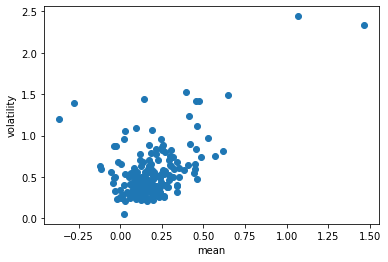

In [14]:
# detect outliers
X = rets_df.values 
pl.scatter(X[:,0],X[:,1])
pl.xlabel("mean")
pl.ylabel("volatility")
pl.savefig('returns_outliers.png')

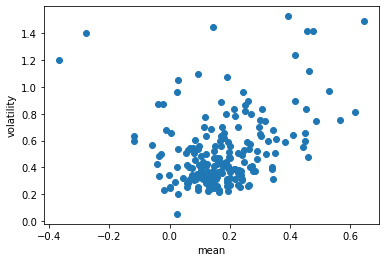

In [15]:
# remove outliers
xx = pd.DataFrame(mean_ret)
xx_sorted = xx.sort_values(by = 0)[-2:].index
outliers = list(xx_sorted)

returns = returns_imp.drop(outliers, 1)
rets_df2 = rets_df.drop(outliers)

X = rets_df2.values 
pl.scatter(X[:,0],X[:,1])
pl.xlabel("mean")
pl.ylabel("volatility")
pl.savefig('returns_outliers2.png')

In [16]:
# training and test set 
cutoff = "2019-12-31"

ret_train = returns[returns.index <= cutoff]

ret_test = returns[returns.index > (datetime.strptime(cutoff, '%Y-%m-%d') -  relativedelta(years=1))]

In [17]:
# annual mean returns and variances 
mean_ret, var_ret = ann_moments(ret_train)

rets_df = pd.concat([mean_ret, var_ret], axis = 1)
rets_df.columns = ["Returns","Volatility"]

# K-Means

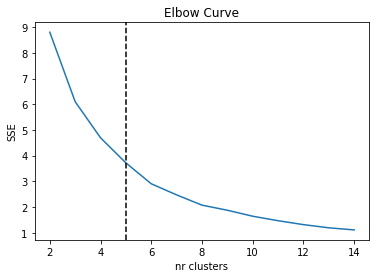

In [18]:
# select optimal number of clusters by minimizing SSE
X =  rets_df.values 
sse = []

random.seed(123)
for k in range(2,15):
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    
    sse.append(kmeans.inertia_) #SSE for each cluster
    
pl.plot(range(2,15), sse)
pl.title("Elbow Curve")
pl.xlabel('nr clusters')
pl.ylabel('SSE')
pl.axvline(x=5, c = "k", linestyle='dashed')
pl.savefig('elbow_rule_kmeans.png')

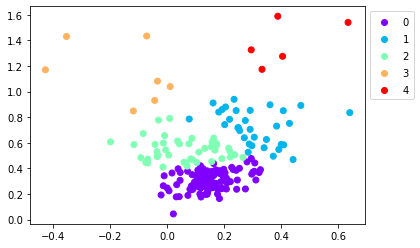

In [19]:
# fit k-means with 5 clusters
X = rets_df.values 
n_clusters = 5

kmeans = KMeans(n_clusters = n_clusters).fit(X)
centroids = kmeans.cluster_centers_

fig, ax = pl.subplots()
scatter = ax.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap = "rainbow")
ax.legend(*scatter.legend_elements(), loc='upper left', bbox_to_anchor=(1, 1))
pl.savefig('kmeans.png')

In [20]:
# count number of elements in each cluster
cluster_idx = np.array(kmeans.labels_)
(unique, counts) = np.unique(cluster_idx, return_counts=True)
frequencies = np.asarray((unique, counts)).T

# get cluster number for each asset
asset = pd.DataFrame(rets_df.index)
cluster_list = pd.concat([asset, pd.DataFrame(cluster_idx)],axis = 1)
cluster_list.columns = ["Asset","Cluster"]

## Rolling portfolio optimization K-Means

In [21]:
# save return series for each cluster in dictionary
ret_dict = cluster_returns(x = cluster_list, y = ret_test)

# compute equally weighted portfolio returns for each cluster
ret_ew = equal_weights(ret_dict)

# optimal portfolio weights on 252 days rolling windows (daily portfolio rebalancing)
pesi_rol = rolling_portfolio(ret_ew, clust_type = "partitional")

In [22]:
# make sure return dates match weight dates 
lgc = ret_ew.index.isin(pesi_rol.index)
ret_subs = ret_ew.iloc[lgc, :]

# select dates for portfolio backtest
dates_backtest = ret_subs.index

In [23]:
# portfolio returns
kmeans_rets = (ret_subs*pesi_rol).sum(axis = 1)

# cumulative returns
kmeans_rol = cumulative_returns(pf_returns = kmeans_rets, d = dates_backtest)

## Static portfolio optimization K-Means

In [24]:
# static portfolio optimization
pesi_static = static_portfolio(ret_ew)

# portfolio returns
kmeans_rets_static = (ret_ew*list(pesi_static.values())).sum(axis = 1)

# cumulative returns
kmeans_static = cumulative_returns(pf_returns = kmeans_rets_static, d = dates_backtest)

# Bounded K-Means

Best partition was found for 8 clusters
Total weight = 196.0
Max_cluster_size = 44.0
Clusters weights: {0: 44.0, 1: 3.0, 2: 26.0, 3: 25.0, 4: 44.0, 5: 28.0, 6: 21.0, 7: 5.0}


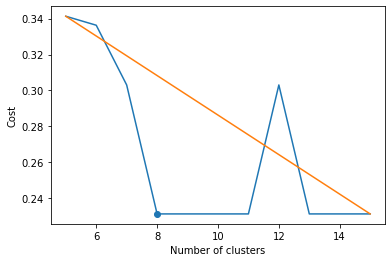

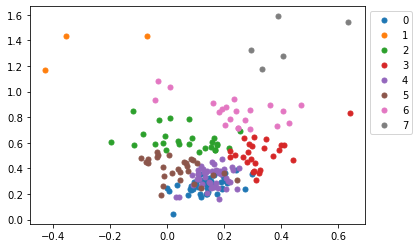

In [25]:
X = rets_df.values

n_clusters = 5
n_iter = 10
weights = np.ones(len(X)) # weight of individual observations set to one 
max_cluster_size = (sum(weights)// n_clusters) + n_clusters

random.seed(123)
cluster_maker = BoundedClustering(max_cluster_size, n_iter) 
best_k, best_clusters = cluster_maker.fit(X, weights)
print(f"Best partition was found for {best_k} clusters")
print(f"Total weight = {sum(weights)}")
print(f"Max_cluster_size = {max_cluster_size}")
print(f"Clusters weights: {dict((i, sum(weights[c])) for i, c in enumerate(best_clusters))}")
ClustersUtils.scatter_plot(X, best_clusters)

In [26]:
# get cluster number for each asset

dict_bkm = {}
for clu, assets in enumerate (best_clusters):
    dict_bkm[clu] = assets

cluster_array = np.zeros(len(X))

for k, it in dict_bkm.items():
    for i in it:
        cluster_array[i] = k

asset = pd.DataFrame(rets_df.index)
cluster_bkm = pd.concat([asset, pd.DataFrame(cluster_array)], axis = 1)
cluster_bkm.columns = ['assets', 'clusters bkm']
cluster_bkm['clusters bkm'] = cluster_bkm['clusters bkm'].astype(int)

## Rolling portfolio Bounded K-Means

In [27]:
# save return series for each cluster in dictionary
ret_dict = cluster_returns(x = cluster_bkm, y = ret_test)

# compute equally weighted portfolio returns for each cluster
ret_ew = equal_weights(ret_dict)

# optimal rolling portfolio weights
pesi_rol_bkm = rolling_portfolio(ret_ew, clust_type = "partitional")

# make sure return dates match weight dates 
lgc = ret_ew.index.isin(pesi_rol_bkm.index)
ret_subs = ret_ew.iloc[lgc, :]

# select dates for portfolio backtest
dates_backtest = ret_subs.index

# portfolio returns
bkm_rets = (ret_subs*pesi_rol_bkm).sum(axis = 1)

# cumulative returns
bkm_rol = cumulative_returns(pf_returns = bkm_rets, d = dates_backtest)


## Static Portfolio Optimization Bounded K-Means

In [28]:
# static portfolio optimization
pesi_bkm_static = static_portfolio(ret_ew)

# portfolio returns
bkm_rets_static = (ret_ew*list(pesi_bkm_static.values())).sum(axis = 1)

# cumulative returns
bkm_static = cumulative_returns(pf_returns = bkm_rets_static, d = dates_backtest)

# Hierarchical risk parity

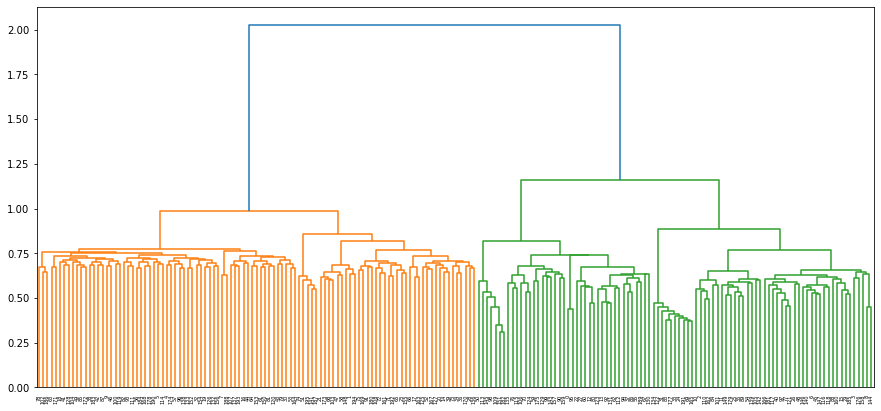

In [29]:
# hrp clusters (from pyhrp package)
cov, cor = ret_train.cov(), ret_train.corr()
links = linkage(dist(cor.values), method='ward')
node = tree(links)

#rootcluster = _hrp(node, cov)
#weights_hrp = rootcluster.weights

fig = plt.figure(figsize=(15,7))
ax = dendrogram(links, orientation="top")
pl.savefig('dendogram.png')

## Static portfolio optimization HRP

In [30]:
# static portfolio weights (from pypfopt package)
hrp = hierarchical_portfolio.HRPOpt(ret_train)
raw_weights = hrp.optimize()
weights_hrp = hrp.clean_weights()
# cluster = hrp.clusters

# match dates
lgc = ret_test.index.isin(dates_backtest)
ret_subs = ret_test.iloc[lgc, :]

# portfolio returns
hrp_rets_static = (ret_subs*list(weights_hrp.values())).sum(axis = 1)

# cumulative returns
hrp_static = cumulative_returns(pf_returns = hrp_rets_static, d = dates_backtest)

## Rolling portfolio optimization HRP

In [31]:
#hrp_pesirol = rolling_portfolio(ret_test, clust_type = "hierarchical")

#hrp_pesirol.to_pickle("./pesi_rolling_hrp.pkl")

In [32]:
# import rolling hrp weights
hrp_pesirol = pd.read_pickle("./pesi_rolling_hrp.pkl")

hrp_pesirol.columns = ret_test.columns

# portfolio returns
hrp_rets_rol = (ret_subs*hrp_pesirol).sum(axis = 1)

# cumulative returns
hrp_rol = cumulative_returns(pf_returns = hrp_rets_rol, d = dates_backtest)

# Benchmark Portfolios

## Rolling tangency portfolio

In [33]:
#tangency_rol = rolling_portfolio(ret_test, clust_type = "none")

#tangency_rol.to_pickle("./pesi_rolling_tangency.pkl")

In [34]:
# import rolling tangency weights
tan_pesirol = pd.read_pickle("./pesi_rolling_tangency.pkl")

# portfolio returns
tan_rets_rol = (ret_subs*tan_pesirol).sum(axis = 1)

# cumulative returns
tan_rol = cumulative_returns(pf_returns = tan_rets_rol, d = dates_backtest)

## Static tangency portfolio

In [35]:
# portfolio weights
cluster_price = expected_returns.prices_from_returns(ret_test)
mu = expected_returns.mean_historical_return(cluster_price)
S = risk_models.sample_cov(cluster_price)
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
tan_pesi_static = ef.clean_weights()

# portfolio returns
tan_rets_st = (ret_subs*tan_pesi_static).sum(axis = 1)

# cumulative returns
tan_static = cumulative_returns(pf_returns = tan_rets_st, d = dates_backtest)

## Equally weighted portfolio

In [36]:
# portfolio returns
ew_rets = ret_subs.mean(axis = 1)

# cumulative returns
ew_rol = cumulative_returns(pf_returns = ew_rets, d = dates_backtest)

# Cluster performance evaluation

In [37]:
X = rets_df.values

# silhouette coefficient 
km_ss = silhouette_score(X, kmeans.labels_, metric = 'euclidean')

bkm_ss = silhouette_score(X, cluster_array.astype(int), metric = 'euclidean')

# calinski_harabasz_score
km_chs = calinski_harabasz_score(X, kmeans.labels_)

bkm_chs = calinski_harabasz_score(X, cluster_array.astype(int))

# Portfolio performance evaluation

In [38]:
# compute portfolio excess returns wrt the risk free rate and the annualized sharpe ratios

names = ["K-Means", "Bounded K-Means", "HRP", "Tangency", "Equal Weights"]
rets_list = [kmeans_rets, bkm_rets, hrp_rets_rol, tan_rets_rol, ew_rets]

for i in range (len(names)): 
    
    if i == 0:
        output = ann_sharpe(rets = rets_list[i], rf_rate = tbill_ann, d = dates_backtest)
        exc_ret = output[0]
        sharpe = np.array(output[1]) 
    else: 
        output = ann_sharpe(rets = rets_list[i], rf_rate = tbill_ann, d = dates_backtest)
        exc_ret = pd.concat( [exc_ret, output[0] ], axis = 1)
        sharpe = np.append( sharpe, output[1] ) 
        
exc_ret.columns = names

In [39]:
# compute annualized portfolio expected returns and volatility

rets_list = [kmeans_rets, bkm_rets, hrp_rets_rol, tan_rets_rol, ew_rets]

for i in range (len(names)): 
    
    if i == 0:
        moments = pd.DataFrame(ann_moments(rets_list[i]))
    else: 
        moments = pd.concat( [moments, pd.DataFrame(ann_moments(rets_list[i]))], axis = 1)
        
moments.columns = names
moments.index = ["returns", "volatility"]

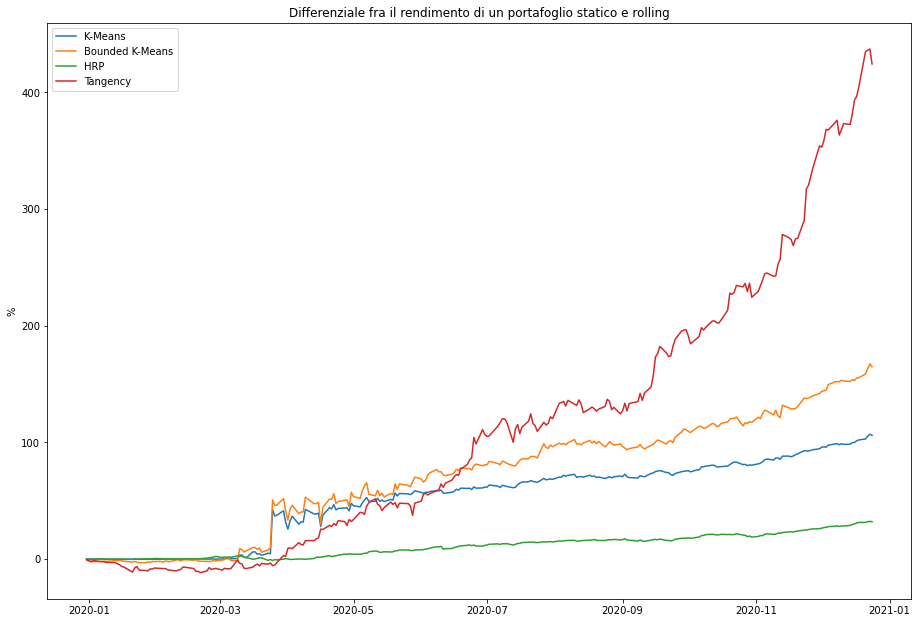

In [40]:
# compute difference between static and rolling portfolio returns
rol_list = [kmeans_rol, bkm_rol, hrp_rol, tan_rol]
static_list = [kmeans_static, bkm_static, hrp_static, tan_static]

for i in range(len(rol_list)):
    
    if i == 0:
        diff_rol = rol_list[i] - static_list[i]
    else:
        diff_rol = pd.concat( [diff_rol, rol_list[i] - static_list[i]], axis = 1)

diff_rol.columns = names[:-1]

# plot
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
plt.plot(diff_rol)
ax1.set_ylabel("%")
ax1.set_title("Differenziale fra il rendimento di un portafoglio statico e rolling")
plt.legend(loc='upper left', labels = names[:-1])
pl.savefig('excess_rolling_static.png')


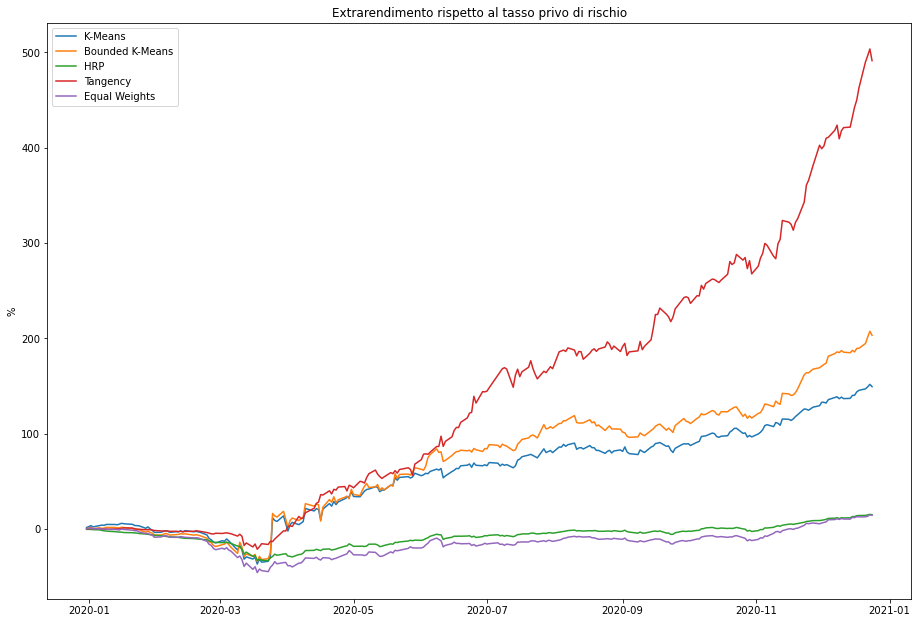

In [41]:
# compute cumulative excess return with respect to risk free rate
for i in range(len(names)):
    
    if i == 0:
        cumret_df = cumulative_returns(pf_returns = exc_ret.iloc[:, i], d = dates_backtest)
    else:
        cumret_df = pd.concat( [cumret_df, 
                                cumulative_returns(pf_returns = exc_ret.iloc[:, i], d = dates_backtest)], 
                              axis = 1)

cumret_df.columns = names

# figure
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
plt.plot(cumret_df)
ax1.set_ylabel("%")
ax1.set_title("Extrarendimento rispetto al tasso privo di rischio")
plt.legend(loc='upper left', labels = names)
pl.savefig('excess_return.png')

# Tables 

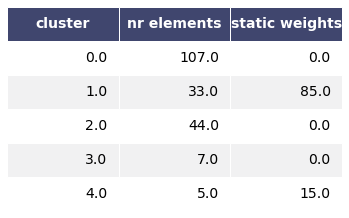

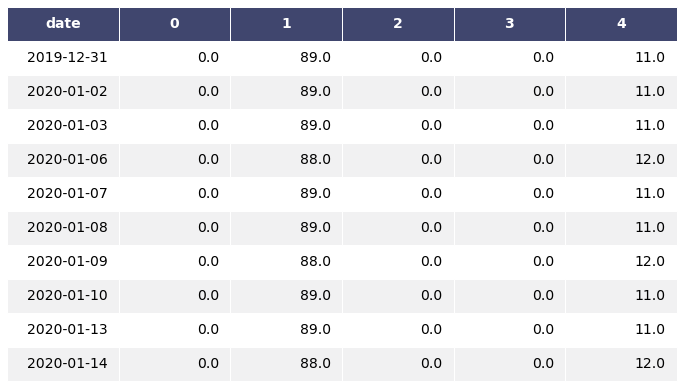

In [42]:
# table kmeans static weights
my_dict = dict(pesi_static)
my_dict.update((x, y*100) for x, y in my_dict.items())

kmeans_tab = pd.DataFrame( )
kmeans_tab["cluster"] = dict(frequencies).keys()
kmeans_tab["nr elements"] = dict(frequencies).values()
kmeans_tab["static weights"] = my_dict.values()

fig,ax = render_mpl_table(kmeans_tab.round(), header_columns=0, col_width=2.0)
fig.savefig("table_kmeans.png")

# table kmeans rolling weights
dates = pesi_rol.index.date

tab_km = pd.DataFrame()
tab_km["date"] = [str(i) for i in dates]
tab_km.index = pesi_rol.index

tab_km_rol = pd.concat([tab_km, (pesi_rol*100)], axis = 1)

fig,ax = render_mpl_table(tab_km_rol.iloc[:10].round(), header_columns=0, col_width=2.0)
fig.savefig("table_km_rolling.png")

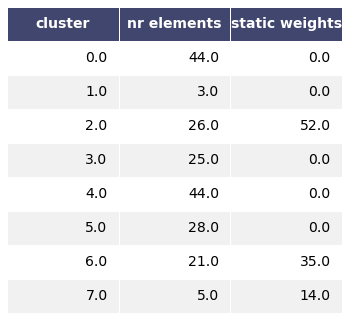

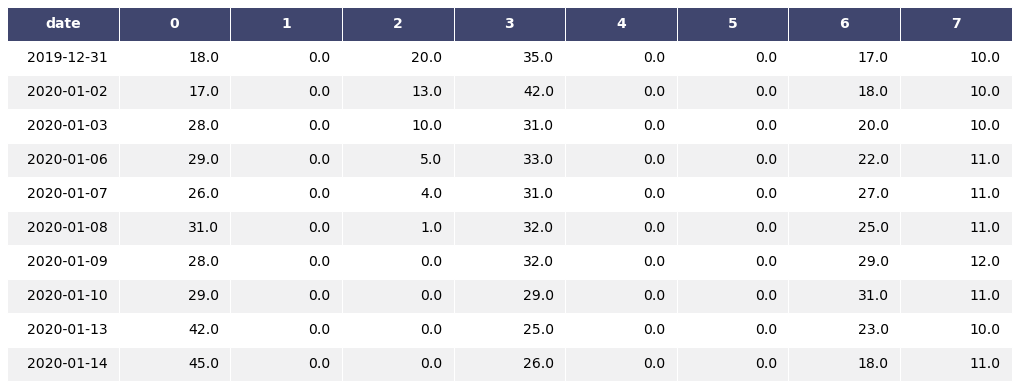

In [43]:
# table bounded-kmeans static weights
my_dict = dict(pesi_bkm_static)
my_dict.update((x, y*100) for x, y in my_dict.items())

cluster_weights = dict((i, sum(weights[c])) for i, c in enumerate(best_clusters))

b_kmeans_tab = pd.DataFrame( )
b_kmeans_tab["cluster"] = cluster_weights.keys()
b_kmeans_tab["nr elements"] = cluster_weights.values()
b_kmeans_tab["static weights"] = my_dict.values()

fig,ax = render_mpl_table(b_kmeans_tab.round(), header_columns=0, col_width=2.0)
fig.savefig("table_b_kmeans.png")

# table b-kmeans rolling weights
dates = pesi_rol_bkm.index.date

tab_bkm = pd.DataFrame()
tab_bkm["date"] = [str(i) for i in dates]
tab_bkm.index = pesi_rol_bkm.index

tab_bkm_rol = pd.concat([tab_bkm, (pesi_rol_bkm*100)], axis = 1)

fig,ax = render_mpl_table(tab_bkm_rol.iloc[:10].round(), header_columns=0, col_width=2.0)
fig.savefig("table_bkm_rolling.png")

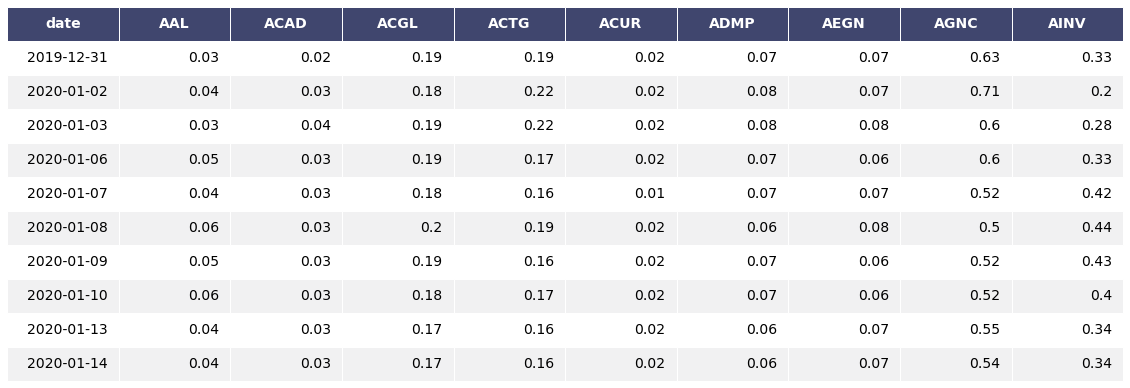

In [44]:
# table hrp rolling weights
dates = hrp_pesirol.index.date

tab_hrp = pd.DataFrame()
tab_hrp["date"] = [str(i) for i in dates]
tab_hrp.index = hrp_pesirol.index

tab_hrp_rol = pd.concat([tab_hrp, (hrp_pesirol*100)], axis = 1)

fig,ax = render_mpl_table(tab_hrp_rol.iloc[:10,:10].round(2), header_columns=0, col_width=2.0)
fig.savefig("table_hrp_rolling.png")


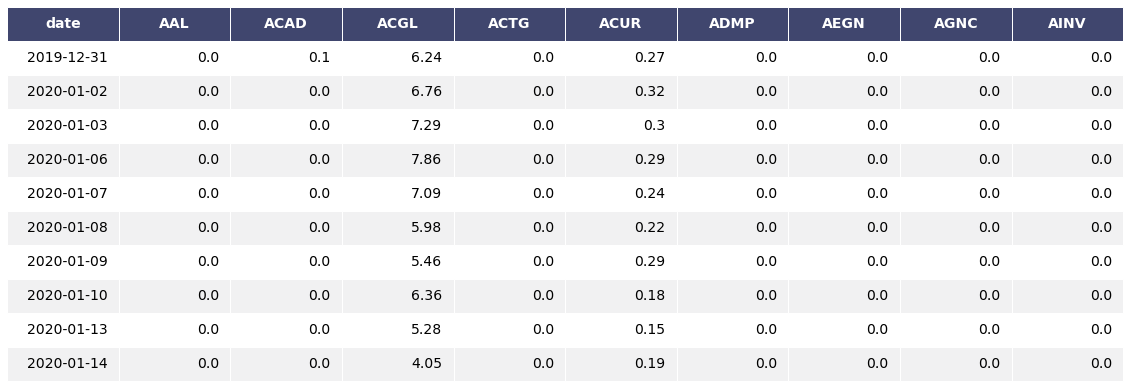

In [45]:
# table tangency portfolio rolling weigths
dates = tan_pesirol.index.date

tab_tan = pd.DataFrame()
tab_tan["date"] = [str(i) for i in dates]
tab_tan.index = tan_pesirol.index

tab_tan_rol = pd.concat([tab_tan, (tan_pesirol*100)], axis = 1)

fig,ax = render_mpl_table(tab_tan_rol.iloc[:10,:10].round(2), header_columns=0, col_width=2.0)
fig.savefig("table_tan_rolling.png")


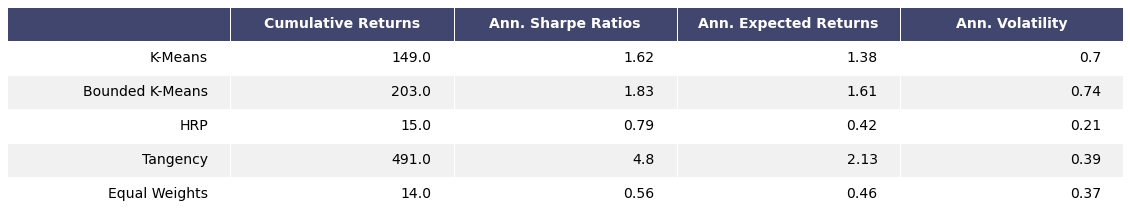

In [98]:
# table of cumulative returns, sharpe ratios, expected returns and volatility
names = ['Cumulative Returns', 'Ann. Sharpe Ratios', "Ann. Expected Returns", "Ann. Volatility"]

all_tab = {}
all_tab[0] = list(cumret_df.iloc[-1,:].round())
all_tab[1] = list(sharpe )
all_tab[2] = list(moments.iloc[0])
all_tab[3] = list(moments.iloc[1])

final_table = pd.DataFrame.from_dict(all_tab)
final_table.columns = names
final_table.index = list( cumret_df.columns )

col_name = pd.DataFrame(list( cumret_df.columns ))
tab_print = pd.merge(col_name, final_table, on = col_name.index)
tab_print = tab_print.drop(['key_0'], axis = 1)
tab_print.columns = [" "] + names
fig,ax = render_mpl_table(tab_print.round(2), header_columns=0, col_width=4.0)
fig.savefig("table_summary.png")

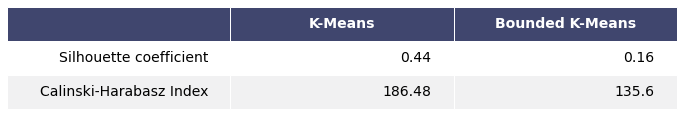

In [47]:
# cluster evaluation table

km_ev = [km_ss, km_chs]
bkm_ev = [bkm_ss, bkm_chs]
ev_type = ['Silhouette coefficient', 'Calinski-Harabasz Index']
ev_df = pd.DataFrame([ev_type, [round(num, 2) for num in km_ev], [round(num, 2) for num in bkm_ev]]).T
ev_df.columns = [" ", "K-Means", "Bounded K-Means"]

fig,ax = render_mpl_table(ev_df, header_columns=0, col_width=4.0)
fig.savefig("table_cluster_ev.png")

In [ ]:
# print full size table
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print (pesi_rol)
